In [1]:
%load_ext autoreload
%autoreload 2

import optax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt


from spring_utils import get_observations, get_zs, get_A
from spring_gradients import marginal_likelihood
from training_spring import fit
from constants import RAND_KEY

### Constants and utils

In [7]:
delta_t = 0.1
m = 3.
k = 20.
z = 0.5

mu0 = jnp.array([3, 1])
V0 = jnp.eye(2) * 0.0001
trans_noise = jnp.eye(2) * 0.01
obs_noise = jnp.eye(2) * 0.5


JAX_KEY = jrandom.PRNGKey(2)

### Generated data

In [8]:
num_steps = 500
N = 4

zs, xs = get_observations(k, delta_t, m, z, mu0, V0, trans_noise, obs_noise, num_steps, N, key=JAX_KEY)

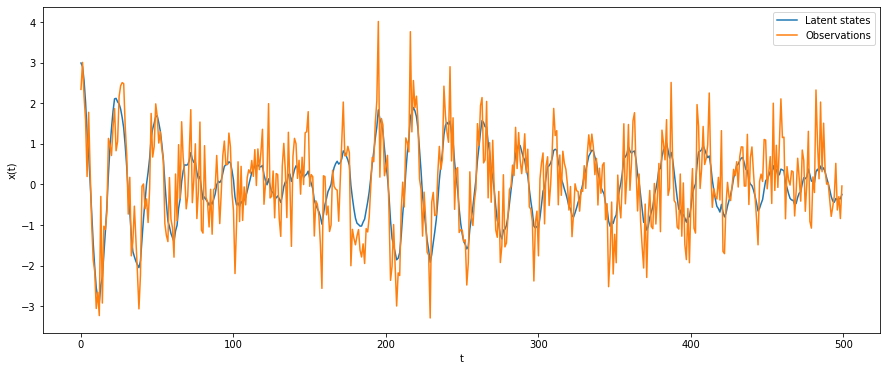

In [9]:
plt.figure(figsize=(15, 6))
plt.plot(zs[:, 0, 0], label="Latent states")
plt.plot(xs[:, 0, 0], label="Observations")
plt.xlabel('t')
plt.ylabel('x(t)')
plt.legend()
plt.savefig('mass_spring_damped.jpg', bbox_inches='tight')
plt.show()

### Learn the dynamics of the mass-spring system

In [10]:
N = 10000
num_steps = 3
NUM_TRAIN_STEPS = 1500

_, xs = get_observations(k, delta_t, m, z, mu0, V0, trans_noise, obs_noise, num_steps, N)

LR_ESTIMATOR = False

A_init = jnp.eye(2)
params = jnp.array([A_init])


optimizer = optax.chain(
    optax.adam(learning_rate=0.0006),
    optax.scale(-1.0)
)

optimizer.init(params)

print(f"True value of A: {get_A(k, delta_t, m, z)}\n")

learned_params, losses, gradients = fit(
    params=params,
    optimizer=optimizer, 
    training_steps=NUM_TRAIN_STEPS, 
    mu0=mu0, V0=V0,
    trans_noise=trans_noise,
    obs_noise=obs_noise, xs=xs, 
    num_steps=num_steps, 
    N=N, 
    lr_estimator=LR_ESTIMATOR,
)

True value of A: [[ 0.93333334  0.09833334]
 [-0.6666667   0.98333335]]

Step 0, marginal likelihood: 0.000001, A - [[ 9.994028e-01 -5.913570e-04]
 [-5.996407e-04  9.994011e-01]]
Step 100, marginal likelihood: 0.000009, A - [[ 0.948067   -0.04867884]
 [-0.08043003  0.9202908 ]]
Step 200, marginal likelihood: 0.000131, A - [[ 0.9584072   0.04939484]
 [-0.20838772  0.79685766]]
Step 300, marginal likelihood: 0.000849, A - [[ 0.9480819   0.2117569 ]
 [-0.35107547  0.6702037 ]]
Step 400, marginal likelihood: 0.001864, A - [[ 0.94023174  0.34574667]
 [-0.4704897   0.60754395]]
Step 500, marginal likelihood: 0.002465, A - [[ 0.9378689   0.38584325]
 [-0.5508885   0.64359474]]
Step 600, marginal likelihood: 0.002699, A - [[ 0.93735254  0.3236221 ]
 [-0.59804976  0.70995647]]
Step 700, marginal likelihood: 0.002771, A - [[ 0.9386723   0.25216958]
 [-0.6247162   0.7678825 ]]
Step 800, marginal likelihood: 0.002821, A - [[ 0.93821305  0.20088412]
 [-0.6395303   0.8139517 ]]
Step 900, marginal li

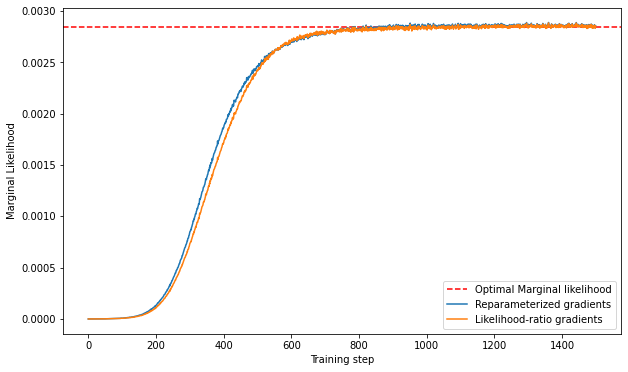

In [15]:
lr_obj = np.load('lr_training_objectives.npy')
rp_obj = np.load('rp_training_objectives.npy')

epsilons = jrandom.normal(key=jrandom.PRNGKey(4), shape=(num_steps, N, 2))

_, xs = get_observations(k, delta_t, m, z, mu0, V0, trans_noise, obs_noise, num_steps, N)
goal = marginal_likelihood(get_A(k, delta_t, m, z), mu0, V0, trans_noise, obs_noise, epsilons, xs)


plt.figure(figsize=(10,6))
plt.axhline(goal, color='red', linestyle='dashed', label="Optimal Marginal likelihood")
plt.plot(rp_obj, label="Reparameterized gradients")
plt.plot(lr_obj, label="Likelihood-ratio gradients")
plt.xlabel('Training step')
plt.ylabel('Marginal Likelihood')
plt.legend()
plt.savefig('gradient_objectives.jpg', bbox_inches='tight')
plt.show()

### Gradient Variance analysis

In [ ]:
NUM_BATCHES = 20
NUM_TRAIN_STEPS = 1500
num_samples = 10000

all_rp_gradients = np.zeros((NUM_BATCHES, NUM_TRAIN_STEPS, 2, 2))
all_lr_gradients = np.zeros((NUM_BATCHES, NUM_TRAIN_STEPS, 2, 2))

key = RAND_KEY

for i in range(NUM_BATCHES):
    key, subkey = jrandom.split(key)
    _, xs = get_observations(
        k, delta_t, m, z, mu0, V0, trans_noise, obs_noise, num_steps, num_samples, key=subkey
    )

    # Reparameterized gradients
    _, _, rp_gradients = fit(
        params=params,
        optimizer=optimizer, 
        training_steps=NUM_TRAIN_STEPS, 
        mu0=mu0, V0=V0,
        trans_noise=trans_noise,
        obs_noise=obs_noise, xs=xs, 
        num_steps=num_steps, 
        N=num_samples, 
        lr_estimator=False,
        key=subkey
    )

    # Likelihood-ratio gradients
    _, _, lr_gradients = fit(
        params=params,
        optimizer=optimizer, 
        training_steps=NUM_TRAIN_STEPS, 
        mu0=mu0, V0=V0,
        trans_noise=trans_noise,
        obs_noise=obs_noise, xs=xs, 
        num_steps=num_steps, 
        N=num_samples, 
        lr_estimator=True,
        key=subkey
    )

    all_rp_gradients[i] = rp_gradients
    all_lr_gradients[i] = lr_gradients

np.save(f'rp_gradient_batches_{num_samples}_samples.npy', all_rp_gradients)
np.save(f'lr_gradient_batches_{num_samples}_samples.npy', all_lr_gradients)

Step 0, marginal likelihood: 0.000001, A - [[ 9.9940115e-01 -5.9634109e-04]
 [-5.9979409e-04  9.9940062e-01]]
Step 100, marginal likelihood: 0.000011, A - [[ 0.9514037  -0.04743735]
 [-0.07720722  0.92358583]]
Step 200, marginal likelihood: 0.000122, A - [[ 0.95701855  0.0316739 ]
 [-0.19901069  0.8066975 ]]
Step 300, marginal likelihood: 0.000795, A - [[ 0.9380199   0.19778952]
 [-0.34300295  0.6776621 ]]
Step 400, marginal likelihood: 0.001942, A - [[ 0.93554443  0.33928633]
 [-0.46824655  0.6059297 ]]
Step 500, marginal likelihood: 0.002595, A - [[ 0.9321348   0.38833183]
 [-0.55090374  0.6422427 ]]
Step 600, marginal likelihood: 0.002822, A - [[ 0.9324278   0.33129182]
 [-0.5971064   0.7128333 ]]
Step 700, marginal likelihood: 0.002899, A - [[ 0.9308495   0.25956094]
 [-0.6226939   0.7743623 ]]
Step 800, marginal likelihood: 0.002980, A - [[ 0.93231845  0.20727421]
 [-0.63733464  0.82380974]]
Step 900, marginal likelihood: 0.002981, A - [[ 0.93075246  0.17214823]
 [-0.64583856  0.8

In [ ]:
all_lr_gradients = all_lr_gradients.reshape(NUM_BATCHES, NUM_TRAIN_STEPS, -1)
lr_grad_var = all_lr_gradients.var(axis=0)[:, 0].mean()
print(lr_grad_var)

all_rp_gradients = all_rp_gradients.reshape(NUM_BATCHES, NUM_TRAIN_STEPS, -1)
rp_grad_var = all_rp_gradients.var(axis=0)[:, 0].mean()
print(rp_grad_var)

9.20747474270388e-05
9.589277548769409e-09


### Consistency check

In [ ]:
NUM_TRAIN_STEPS = 1500
samples = np.linspace(1e1, 1e6, 6, dtype=int)

A_init = jnp.eye(2)
params = jnp.array([A_init])


optimizer = optax.chain(
    optax.adam(learning_rate=0.01),
    optax.scale(-1.0)
)

optimizer.init(params)

A_diffs = np.zeros((samples.shape[0], NUM_TRAIN_STEPS, 4))

for i, num_samples in enumerate(samples):
    _, xs = get_observations(
        k, delta_t, m, mu0, V0, trans_noise, obs_noise, num_steps, num_samples
    )

    # Reparameterized gradients
    _, _, rp_gradients = fit(
        params=params,
        optimizer=optimizer, 
        training_steps=NUM_TRAIN_STEPS, 
        mu0=mu0, V0=V0,
        trans_noise=trans_noise,
        obs_noise=obs_noise, xs=xs, 
        num_steps=num_steps, 
        N=num_samples, 
        lr_estimator=False,
    )

    # Likelihood-ratio gradients
    _, _, lr_gradients = fit(
        params=params,
        optimizer=optimizer, 
        training_steps=NUM_TRAIN_STEPS, 
        mu0=mu0, V0=V0,
        trans_noise=trans_noise,
        obs_noise=obs_noise, xs=xs, 
        num_steps=num_steps, 
        N=num_samples, 
        lr_estimator=True,
    )

    cur_diffs = np.abs(lr_gradients - rp_gradients).reshape(NUM_TRAIN_STEPS, -1)
    A_diffs[i] = cur_diffs


Step 0, marginal likelihood: 0.000004, A - [[ 0.99000835 -0.00997492]
 [-0.00999857  0.9900042 ]]
Step 100, marginal likelihood: 0.000257, A - [[ 1.0204626  -0.917112  ]
 [-0.46847987  0.6983937 ]]
Step 200, marginal likelihood: 0.000251, A - [[ 1.1212926  -1.4614766 ]
 [-0.54803246  1.0249805 ]]
Step 300, marginal likelihood: 0.000314, A - [[ 1.1442819 -1.6850668]
 [-0.6222838  1.2870106]]
Step 400, marginal likelihood: 0.000317, A - [[ 1.1697973 -1.8408183]
 [-0.682542   1.5226305]]
Step 500, marginal likelihood: 0.000288, A - [[ 1.212611   -1.9272764 ]
 [-0.72521293  1.652775  ]]
Step 600, marginal likelihood: 0.000315, A - [[ 1.2197871 -1.9524193]
 [-0.750394   1.7700075]]
Step 700, marginal likelihood: 0.000329, A - [[ 1.2259282  -2.0302541 ]
 [-0.77166915  1.8395832 ]]
Step 800, marginal likelihood: 0.000347, A - [[ 1.2508999 -2.0701828]
 [-0.7979242  1.8987917]]
Step 900, marginal likelihood: 0.000345, A - [[ 1.221443  -2.1043334]
 [-0.7906507  1.9871585]]
Step 1000, marginal li

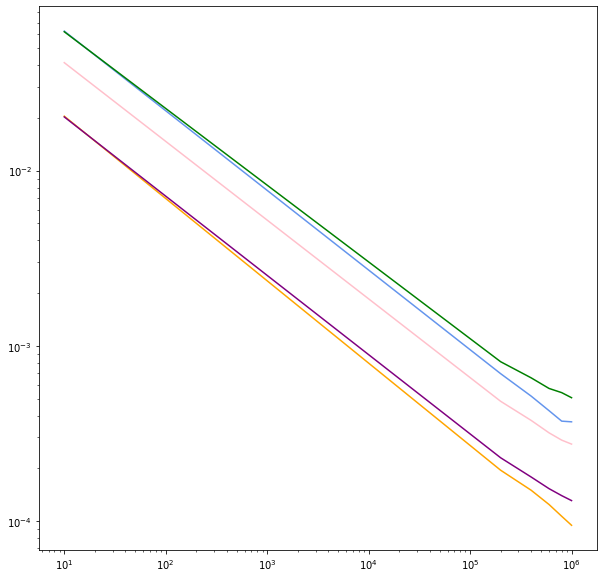

In [ ]:
caca = np.load("A_diffs.npy")
plt.figure(figsize=(10,10))
plt.plot(samples, caca[:, :, 0].mean(axis=1), color="cornflowerblue", label="A[0,0]")
plt.plot(samples, caca[:, :, 1].mean(axis=1), color="orange", label="A[0,1]")
plt.plot(samples, caca[:, :, 2].mean(axis=1), color="green", label="A[1,0]")
plt.plot(samples, caca[:, :, 3].mean(axis=1), color="purple", label="A[1,1]")
plt.plot(samples, caca[:, :, :].mean(axis=(1,2)), color="pink", label="Average")
plt.xscale('log')
plt.yscale('log')
plt.show()